In [1]:
# Import packages
from __future__ import division, unicode_literals, print_function
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp
import scipy, pims
from scipy import interpolate, signal
from libtiff import TIFF
from pandas import DataFrame, Series  # for convenience

import metamorph_timestamps

mpl.rc('figure',  figsize=(7, 7))
mpl.rc('image', cmap='gray')

pi = np.pi
cos, sin = np.cos, np.sin

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [2]:
# len of array
N = 80

# S, L : shortest, longest time interval of rotation
S, L = 1,5

# alternate CW, CCW for each index in array
fake_time_steps = np.random.randint(S, L+1, N-1) # Note: may want to have different distributions for CW and CCW intervals

# all angles between 0 and pi spaced by pi/8
fixed_angles = np.r_[0:pi/8:pi/128] # NOTE: the denominators may have to change for spacing

In [3]:
# rotate a point in R2 by theta radians about the point (0,0)
def rotate(point, theta):
    mtx = np.array([
            [cos(theta), -sin(theta)],
            [sin(theta), cos(theta)]])
    return np.dot(mtx, point)

def add_noise_to_point(point, sigma=.1):
    new_x = point[0] + np.random.normal(0, sigma)
    new_y = point[1] + np.random.normal(0, sigma)
    return [new_x, new_y]

# def rotate_n_times(point, theta, n):
#     return rotate(point, n*theta)

In [4]:
# initial point
init_angle = 2*pi * np.random.rand()
p_init = np.array([cos(init_angle), sin(init_angle)]) # remember this isn't randomly initialized right now
angles = []

# iterate fake_time_steps and generate points
add_noise = True
points = [p_init]
is_CCW = False
for step in fake_time_steps:
    rand_idx = np.random.randint(0,len(fixed_angles))
    theta = fixed_angles[rand_idx]
    if is_CCW:
        theta = -theta
    is_CCW = not is_CCW
    
    for i in range(step):
        p_init = rotate(p_init, theta)
        if add_noise:
            points.append(add_noise_to_point(p_init))
        else:
            points.append(p_init)
        angles.append(theta*step)

points = np.array(points)

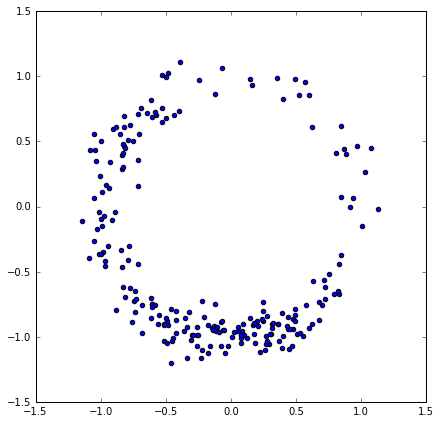

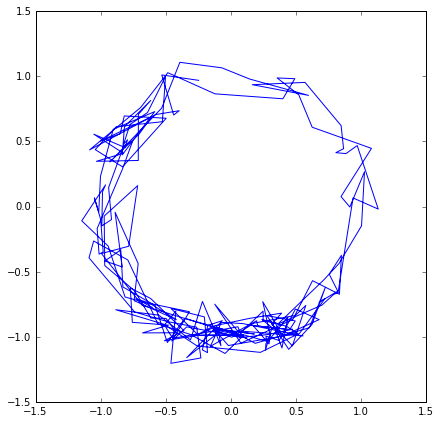

In [5]:
# plot points
plt.figure()
plt.scatter(points[:,0], points[:,1])

plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(points[:,0], points[:,1])

In [6]:
# find angle of rotation between every consecutive pair of points
# NOTE: inverse cosine will always give us an angle between 0 and pi
def angle_sign(b, a):
    # Represents magnitude and direction of rotation.
    # + if b is on CW side of a,
    # - if b is on CCW side of a,
    # 0 if b is parallel to a.
    return np.sign(a[1]*b[0] - a[0]*b[1])

def find_angle(p0, p1):
    return angle_sign(p0, p1)*np.arccos(np.dot(p0, p1)/np.sqrt(np.dot(p0, p0)*np.dot(p1, p1)))

extracted_angles = []
for i in range(len(points)-1):
    first = points[i]
    second = points[i+1]
    extracted_theta = find_angle(first, second)
    extracted_angles.append(extracted_theta)

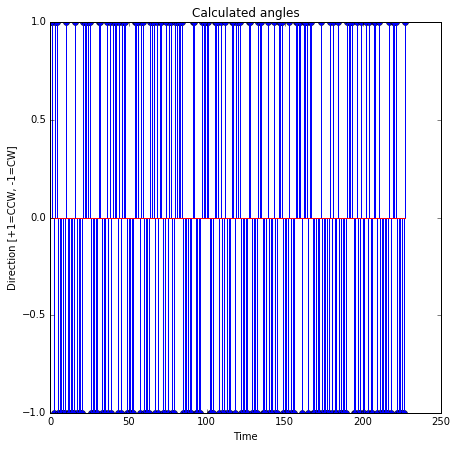

In [7]:
rot_dirs = np.sign(extracted_angles)
plt.stem(rot_dirs)
plt.title('Calculated angles')
plt.xlabel('Time')
plt.ylabel('Direction [+1=CCW, -1=CW]')

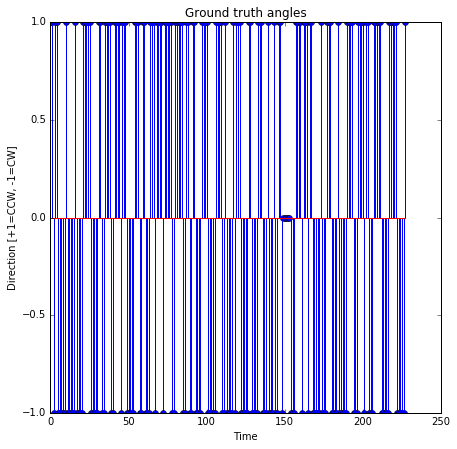

In [8]:
plt.stem(np.sign(angles))
plt.title('Ground truth angles')
plt.xlabel('Time')
plt.ylabel('Direction [+1=CCW, -1=CW]')

In [9]:
def get_bias(angles):
    rot_dirs = np.sign(angles)
    return np.sum(0.5*(rot_dirs + 1))/len(angles)

In [10]:
# Confirming bias is same b/w angles and extracted_angles
get_bias(angles), get_bias(extracted_angles)

(0.48026315789473684, 0.42982456140350878)

In [11]:
def moving_bias(angles, window_size=7):
    rot_dirs = np.sign(angles)
    shifted_angles = 0.5*(rot_dirs + 1)
    window = np.ones(window_size)
    convolved = scipy.signal.fftconvolve(shifted_angles, window)/window_size # default is 'full' convolution
    return convolved

In [12]:
extracted_bias = moving_bias(extracted_angles)
true_bias = moving_bias(angles)

def plot_bias(got_bias, title='Change in bias over time'):
    plt.figure()
    plt.title(title)
    plt.xlabel('Time'); plt.ylabel('Bias')
    plt.stem(got_bias, linefmt='b-', markerfmt='bo')
    plt.plot(np.linspace(0,len(got_bias),len(got_bias)), 0.5*np.ones(len(got_bias)),
             ls='--', c='red', lw=4, label='Bias = 0.5')
    plt.legend(loc='upper right')
    plt.axis('tight')
    plt.ylim(0,1.01)
    plt.show()

In [13]:
def overlay_bias_plots(got_bias, got_bias2, title='Change in bias over time'):
    plt.figure()
    plt.title(title)
    plt.xlabel('Time'); plt.ylabel('Bias')
    plt.stem(got_bias, linefmt='b-', markerfmt='bo')
    plt.stem(got_bias2, linefmt='r-', markerfmt='ro')
    plt.plot(np.linspace(0,len(got_bias),len(got_bias)), 0.5*np.ones(len(got_bias)),
             ls='--', c='red', lw=4, label='Bias = 0.5')
    plt.legend(loc='upper right')
    plt.axis('tight')
    plt.ylim(0,1.01)
    plt.show()

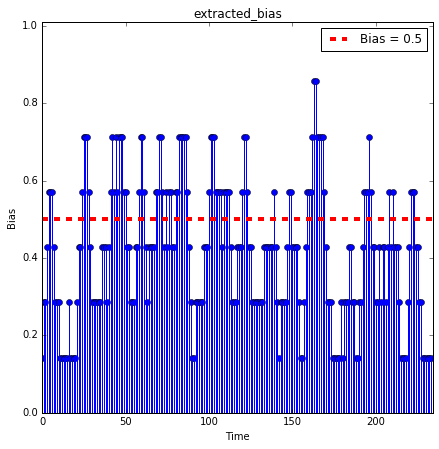

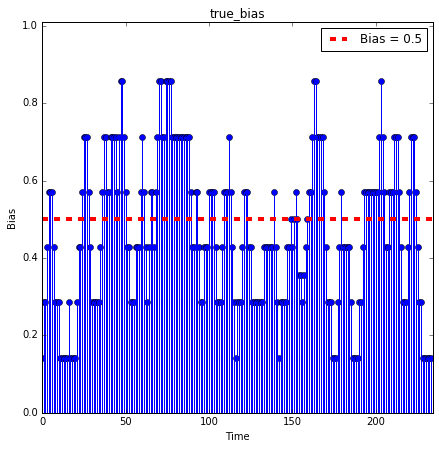

In [14]:
plot_bias(extracted_bias, 'extracted_bias')
plot_bias(true_bias, 'true_bias')

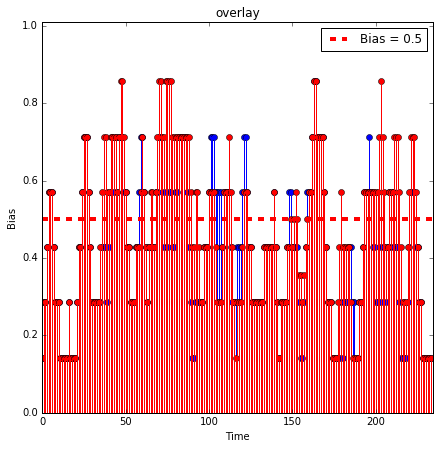

In [15]:
overlay_bias_plots(extracted_bias, true_bias, 'overlay')

<Container object of 3 artists>

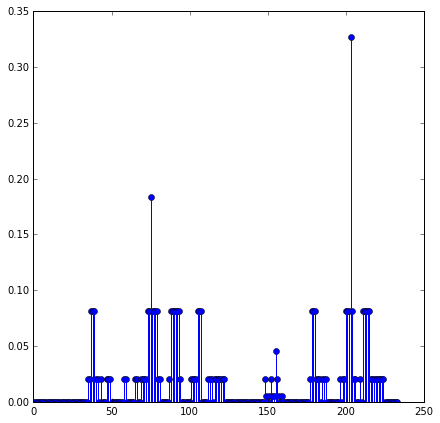

In [16]:
plt.stem(abs(extracted_bias - true_bias)**2)

In [17]:
np.sqrt(np.sum(abs(extracted_bias - true_bias)**2))

2.0590764721999388